# **Como usar Data Science para fazer a empresa vender mais?**

### Problema de Negócio

**A Empresa Insurance All**

**Disclaimer:** O Contexto a seguir, é completamente fictício, a empresa, o contexto, o CEO, as perguntas de negócio existem somente na minha imaginação. 

A Insurance All é uma empresa que fornece seguro de saúde para seus clientes e o time de produtos está analisando a possibilidade de oferecer aos assegurados, um novo produto: Um seguro de automóveis.

Assim como o seguro de saúde, os clientes desse novo plano de seguro de automóveis precisam pagar um valor anualmente à Insurance All para obter um valor assegurado pela empresa, destinado aos custos de um eventual acidente ou dano ao veículo.

A Insurance All fez uma pesquisa com cerca de 304 mil clientes sobre o interesse em aderir a um novo produto de seguro de automóveis, no ano passado. Todos os clientes demonstraram interesse ou não em adquirir o seguro de automóvel e essas respostas ficaram salvas em um banco de dados junto com outros atributos dos clientes.

O time de produtos selecionou 76 mil novos clientes que não responderam a pesquisa para participar de uma campanha, no qual receberão a oferta do novo produto de seguro de automóveis. A oferta será feita pelo time de vendas através de ligações telefônicas.

Contudo, o time de vendas tem uma capacidade de realizar 20 mil ligações dentro do período da campanha.

**Objetivo:**

Construir um modelo de Machine Learning para o time de vendas conseguir priorizar as pessoas com maior interesse no novo produto e assim, otimizar a campanha realizando apenas contatos aos clientes mais propensos a realizar a compra.

**Questões a serem respondidas:**

- Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.

- Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?

- E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

- Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

**Os Dados do Desafio**

- Id: identificador único do cliente.
- Gender: gênero do cliente.
- Age: idade do cliente.
- Driving License: 0, o cliente não tem permissão para dirigir e 1, o cliente tem para dirigir ( CNH – Carteira Nacional de Habilitação )
- Region Code: código da região do cliente.
- Previously Insured: 0, o cliente não tem seguro de automóvel e 1, o cliente já tem seguro de automóvel.
- Vehicle Age: idade do veículo.
- Vehicle Damage: 0, cliente nunca teve seu veículo danificado no passado e 1, cliente já teve seu veículo danificado no passado.
- Anual Premium: quantidade que o cliente pagou à empresa pelo seguro de saúde anual.
- Policy sales channel: código anônimo para o canal de contato com o cliente.
- Vintage: número de dias que o cliente se associou à empresa através da compra do seguro de saúde.
- Response: 0, o cliente não tem interesse e 1, o cliente tem interesse.

# 1.0 - Importações e Funções

In [1]:
import pandas                  as pd
import seaborn                 as sns
import matplotlib.pyplot       as plt
import numpy                   as np
import scikitplot              as skplt

from IPython.display           import Image
from xgboost                   import XGBClassifier
from sklearn.tree              import DecisionTreeClassifier
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.dummy             import DummyClassifier
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split, cross_validate, StratifiedKFold
from sklearn.ensemble          import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics           import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score
from sklearn.preprocessing     import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.under_sampling   import NearMiss
from sklearn.model_selection   import train_test_split
from imblearn.over_sampling    import SMOTE 
from sklearn.svm               import SVC


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Função para criar range de idades para visualizar melhor graficamente.
def age_range(age):
    if age < 31:
        return 1
    elif age >= 31 and age < 42:
        return 2
    elif age >= 42 and age < 53:
        return 3
    elif age >= 53 and age < 64:
        return 4
    elif age >= 64 and age < 75:
        return 5
    else: 
        return 6
        

In [3]:
# Função para criar range de valor pago para visualizar melhor graficamente.
def annual_premmium_range(valor):
    if valor < 100000:
        return 1
    elif valor >= 100000 and valor < 200000 :
        return 2
    elif valor >= 200000 and valor < 300000:
        return 3
    elif valor >= 300000 and valor < 400000:
        return 4
    elif valor >= 400000 and valor < 500000:
        return 5
    else: 
        return 6
        

In [4]:
def cross_validation (modelo, model_name, X_train, y_train, k=10):
    
    precision = []
    recall = []
    
    X_l = X_train.values
    y_l = y_train.values
    
    for train, test in skf.split(X_l, y_l):

        X_train_cv, X_test_cv = X_l[train], X_l[test]
        y_train_cv, y_test_cv = y_l[train], y_l[test]
    
        modelo.fit(X_train_cv, y_train_cv)
        pred = modelo.predict_proba(X_test_cv)
    
        data = X_test_cv.copy()
        data = pd.DataFrame(data)
        
        data['response'] = y_test_cv.tolist()
        data['score'] = pred[:, 1].tolist()
        data = data.sort_values( 'score', ascending=False )
        data = data.reset_index( drop=True )
        data['ranking'] = data.index + 1 
        data['precision_at_k'] = data['response'].cumsum() / data['ranking']
        data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
        precision.append(data.loc[k, 'precision_at_k'])
        recall.append(data.loc[k, 'recall_at_k'])
    
    return pd.DataFrame( {'Model Name': model_name,
                        'Precision' : (np.mean(precision).round(2)),
                        'Recall': (np.mean(recall).round(4))}, index=[0])

# 2.0 -  Análise Descritiva 

In [194]:
df = pd.read_csv('train.csv')

In [195]:
df.sample(5)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
143296,143297,Female,22,1,14.0,1,< 1 Year,No,25467.0,152.0,143,0
6921,6922,Female,22,1,25.0,0,< 1 Year,Yes,28537.0,152.0,111,0
258590,258591,Female,64,1,50.0,1,1-2 Year,No,36812.0,8.0,125,0
45595,45596,Female,43,1,46.0,1,1-2 Year,No,28341.0,26.0,12,0
168747,168748,Male,42,1,3.0,0,1-2 Year,Yes,25437.0,156.0,117,0


## 2.1 - Data Shape

In [196]:
df.shape

(381109, 12)

## 2.2 - Data Info

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 2.3 - Data Describe

In [198]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
Age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Driving_License,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
Region_Code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
Previously_Insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
Annual_Premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Policy_Sales_Channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
Vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
Response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


# 3.0 - Feature Enginnering 

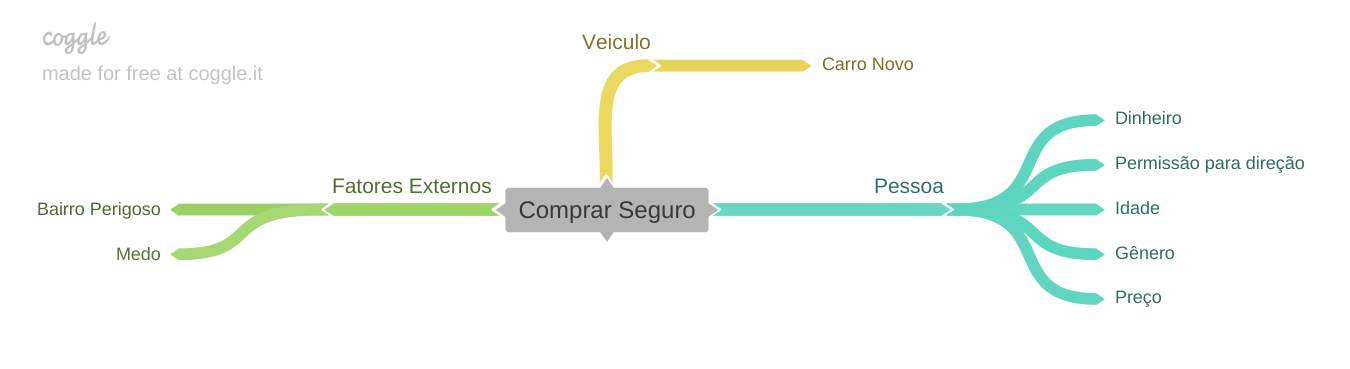

In [199]:
Image ('Comprar_Seguro.png')

## 3.1 - Criação das Hipóteses

**Hipótese do Veículo**

**1.** Clientes com carros mais novos tem mais propensão a comprar seguro.

**Hipótese da Pessoa**

**1.** Clientes que pagam um valor mais alto de seguro de vida tem mais propensão a comprar o seguro.<br/>
**2.** Clientes com mais idade tem mais propensão a comprar o seguro.<br/>
**3.** Homens tem mais propensão a comprar o seguro.<br/>
**4.** Clientes que tem carta de motorista tem mais propensão a comprar o seguro.<br/>
**5.** Cliente que já tiveram o carro danificado no passado tem mais propensão a comprar o seguro.

## 3.2 - Feature Engineering

In [200]:
df['DrivingLicense_PreviouslyInsured'] = df['Driving_License']+df['Previously_Insured']

df['Age_Range'] = df['Age'].apply(age_range)

df['Annual_Premium_range'] = df['Annual_Premium'].apply(annual_premmium_range)

## 3.3 Separação de variavéis númericas e categoricas

In [12]:
df_cat = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')

# 4.0 - Análise Exploratória

## 4.1 - Análise univariada

### 4.1.1 - Variável Resposta

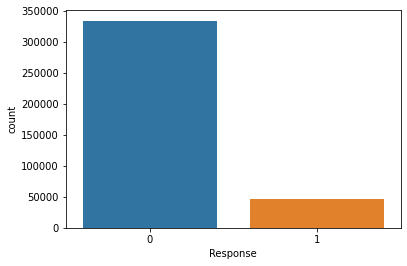

In [13]:
# Os dados estão desbalanceados. A grande maioria não tem interesse em efetuar a compra do seguro.
sns.countplot(x='Response', data=df);

### 4.1.2 - Variáveis númericas

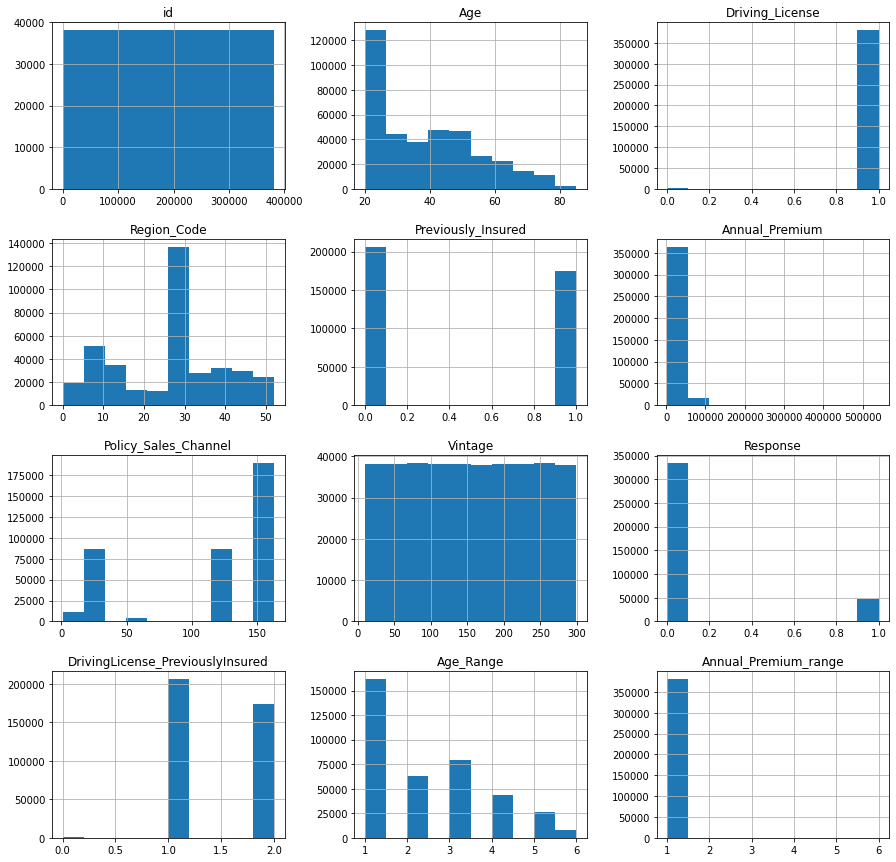

In [14]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
df_num.hist(ax=ax);

### 4.1.3 - Variáveis Categoricas

In [15]:
df_cat.apply(lambda x: x.unique())

Gender                             [Male, Female]
Vehicle_Age       [> 2 Years, 1-2 Year, < 1 Year]
Vehicle_Damage                          [Yes, No]
dtype: object

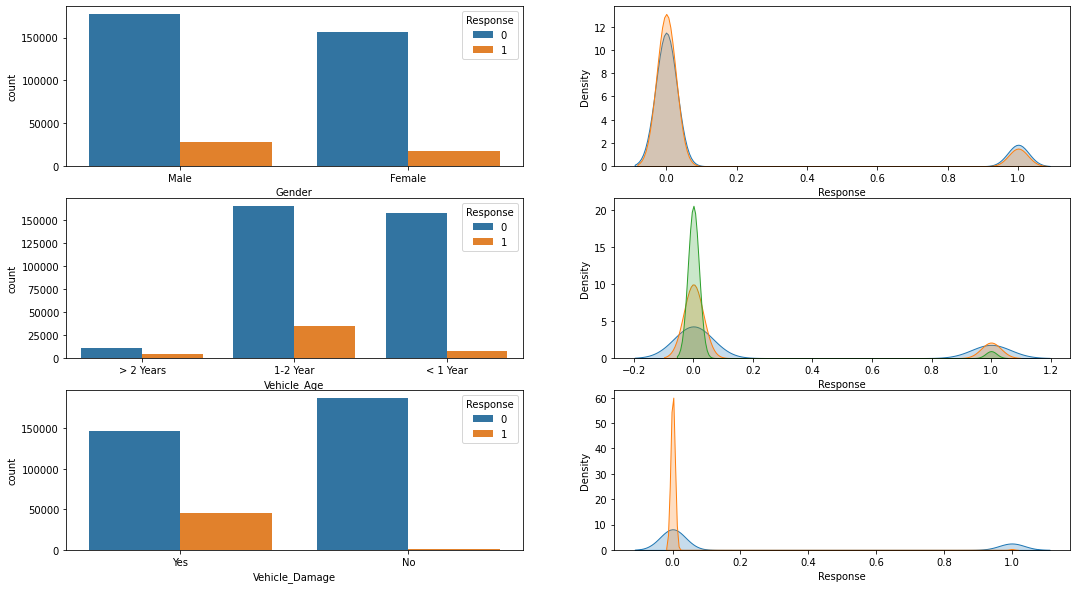

In [16]:
plt.figure(figsize=(18,10))
plt.subplot(3,2,1)
sns.countplot(x='Gender', hue='Response', data=df)

plt.subplot(3,2,2)
sns.kdeplot(df[df['Gender'] == 'Male']['Response'],label='Male', shade=True)
sns.kdeplot(df[df['Gender'] == 'Female']['Response'], label='Female', shade=True)

plt.subplot(3,2,3)
sns.countplot(x='Vehicle_Age', hue='Response', data=df)

plt.subplot(3,2,4)
sns.kdeplot(df[df['Vehicle_Age'] == '> 2 Years']['Response'],label='> 2 Years', shade=True)
sns.kdeplot(df[df['Vehicle_Age'] == '1-2 Year']['Response'], label='1-2 Year', shade=True)
sns.kdeplot(df[df['Vehicle_Age'] == '< 1 Year']['Response'], label='< 1 Year', shade=True)

plt.subplot(3,2,5)
sns.countplot(x='Vehicle_Damage', hue='Response', data=df)

plt.subplot(3,2,6)
sns.kdeplot(df[df['Vehicle_Damage'] == 'Yes']['Response'], label='Yes', shade=True)
sns.kdeplot(df[df['Vehicle_Damage'] == 'No']['Response'],  label='No', shade=True);

In [17]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response',
       'DrivingLicense_PreviouslyInsured', 'Age_Range',
       'Annual_Premium_range'],
      dtype='object')

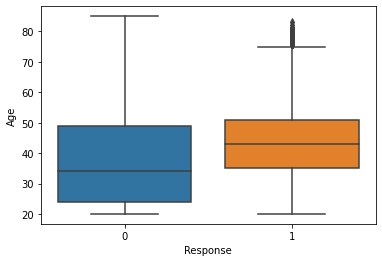

In [18]:
# Gender
sns.boxplot(x='Response', y='Age', data=df);

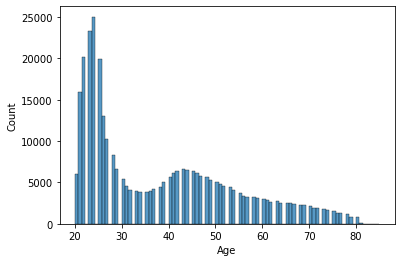

In [19]:
aux = df[(df['Response']==0)]
sns.histplot(aux['Age']);

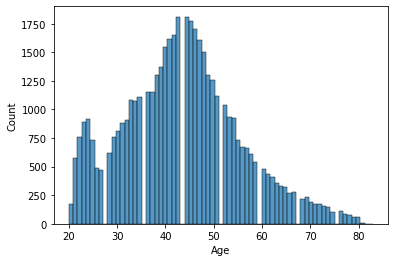

In [20]:
aux = df[(df['Response']==1)]
sns.histplot(aux['Age']);

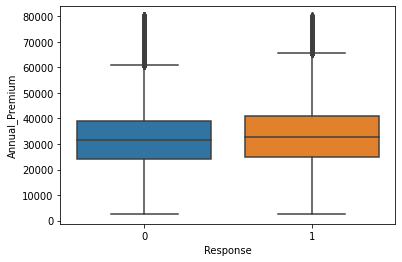

In [21]:
# Annual Premium
aux = df[(df['Annual_Premium'] < 80000)]
sns.boxplot(x='Response', y='Annual_Premium', data=aux);

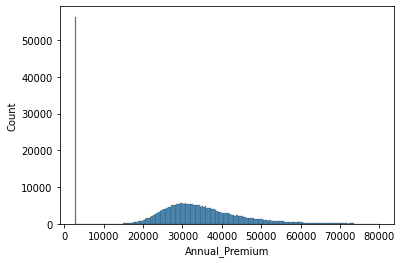

In [22]:
aux = df[(df['Response']==0) & (df['Annual_Premium']<80000)]
sns.histplot(aux['Annual_Premium']);

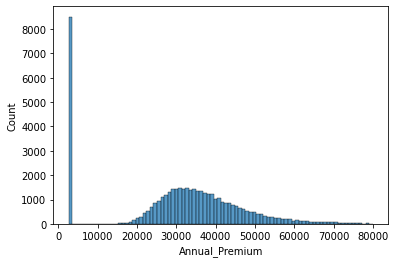

In [23]:
aux = df[(df['Response']==1) & (df['Annual_Premium']<80000)]
sns.histplot(aux['Annual_Premium']);

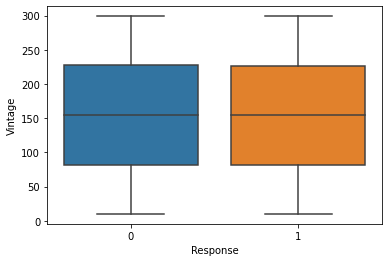

In [24]:
# Vintage
sns.boxplot(x='Response', y='Vintage', data=df);

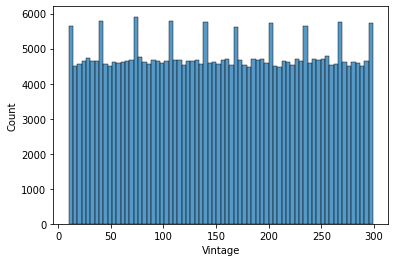

In [25]:
aux = df[(df['Response']==0)]
sns.histplot(aux['Vintage']);

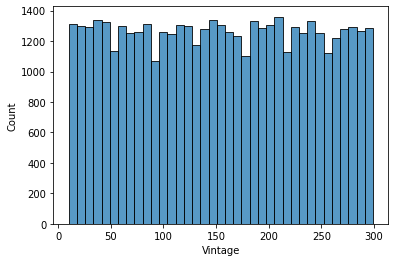

In [26]:
aux = df[(df['Response']==1)]
sns.histplot(aux['Vintage']);

## 4.2 - Análise Bivariada

**H1 - Os clientes que possuem os carros mais novos são mais interessados em seguro?**

**R:** Falso. Em média os clientes que possuem carros com mais de dois anos tem mais interesse em comprar o seguro.

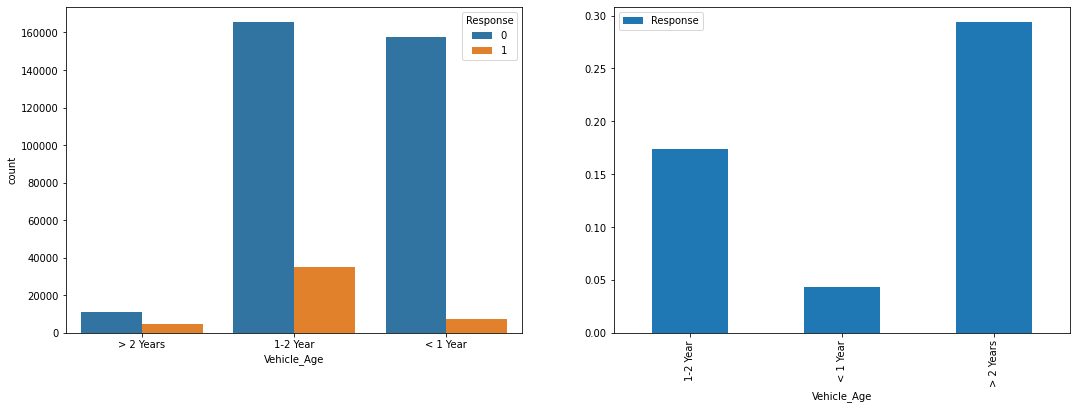

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Vehicle_Age', hue='Response', data=df, ax=ax[0]);

aux1 = df[['Vehicle_Age', 'Response']].groupby('Vehicle_Age').mean();
aux1.plot.bar(ax=ax[1]);


**H2 - Clientes que pagam um valor mais alto de seguro de vida tem mais propensão a comprar o seguro.**

**R:** Verdadeiro. Em média, clientes que pagam de 400 mil a 500 mil são os mais interessados em comprar o seguro.

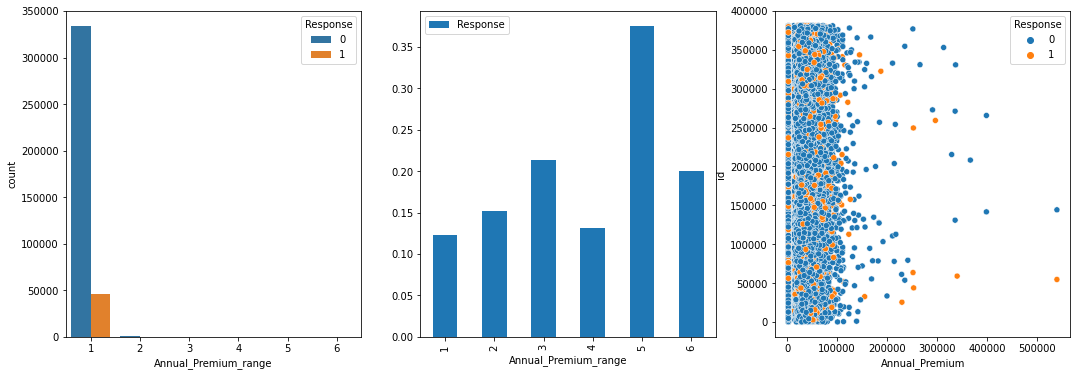

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
sns.countplot(x='Annual_Premium_range', hue='Response', data=df,ax=ax[0])

aux1 = df[['Annual_Premium_range', 'Response']].groupby('Annual_Premium_range').mean()
aux1.plot.bar(ax=ax[1]);

aux2 = df.sample(100000)
sns.scatterplot(x='Annual_Premium', y='id', hue='Response', data=aux2,ax=ax[2]);

**H3 - Clientes com mais idade tem mais propensão a comprar o seguro.**

**R:** Falso. Em média os clientes de meia idade tem mais interesse em comprar o seguro.

**Qual idade que já tem seguro contratado?**

**R:** As pessoas mais jovens (até 30 anos) são as já tem seguro contratado.

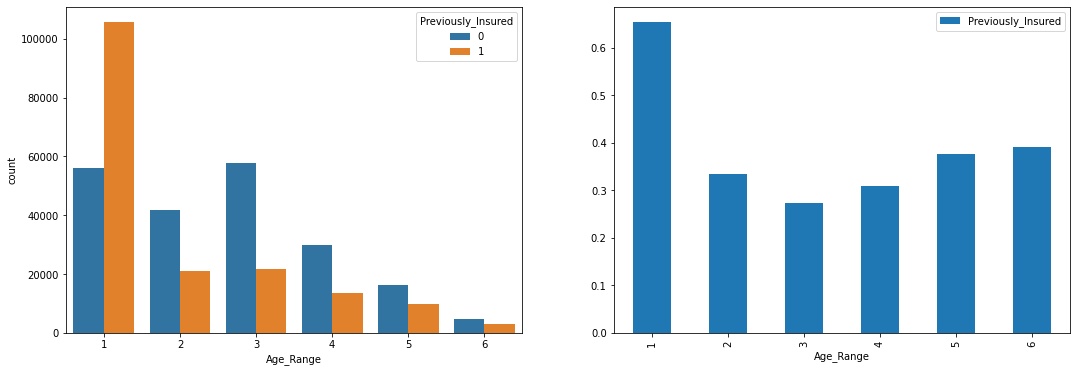

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Age_Range', hue='Previously_Insured', data=df, ax=ax[0]);

aux1 = df[['Age_Range', 'Previously_Insured']].groupby('Age_Range').mean();
aux1.plot.bar(ax=ax[1]);

**Qual idade está mais propensa a comprar o seguro?**

**R:** Em média, quem está no Age_Range 2 e 3 (de 31 até 53 anos) tem mais propensão a contratar um seguro.

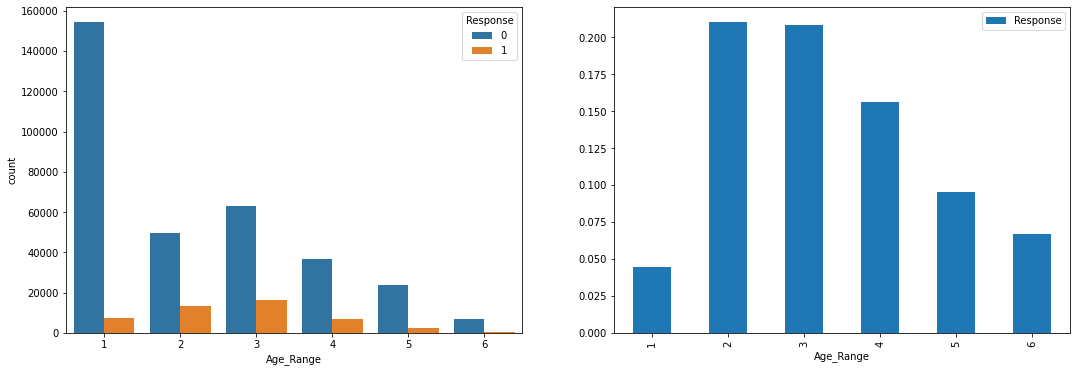

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Age_Range', hue='Response', data=df, ax=ax[0]);

aux1 = df[['Age_Range', 'Response']].groupby('Age_Range').mean()
aux1.plot.bar(ax=ax[1]);

**H4 - Homens tem mais propensão a comprar o seguro.**

**R:** Verdadeiro. Em média os clientes do gênero Masculino possuem interesse em comprar o seguro do que o gênero feminino.

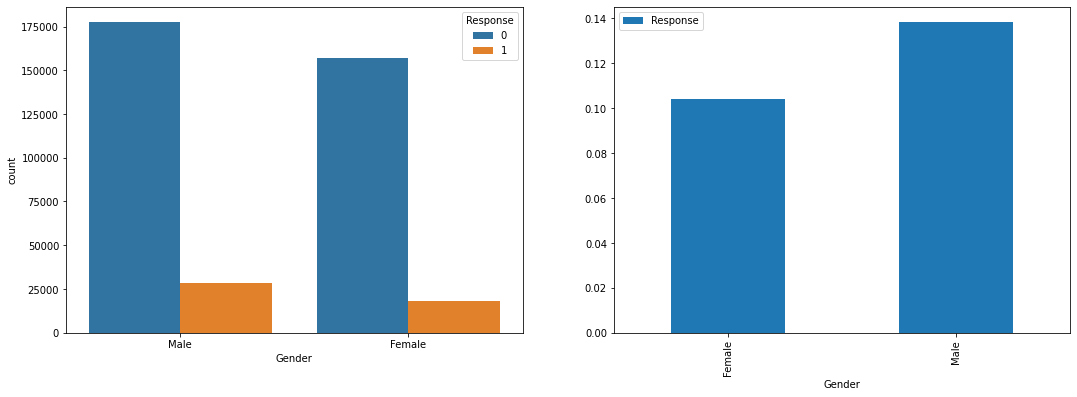

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Gender', hue='Response', data=df, ax=ax[0]);

aux1 = df[['Gender', 'Response']].groupby('Gender').mean();
aux1.plot.bar(ax=ax[1]);


**H5 - Clientes que tem carta de motorista tem mais propensão a comprar o seguro.**

**R:** Verdadeiro. A grande maioria das pessoas da amostra possui carteira de habilitação. Porém, é grande o número de pessoas que não possuem carta e tem interesse em contratar o seguro.

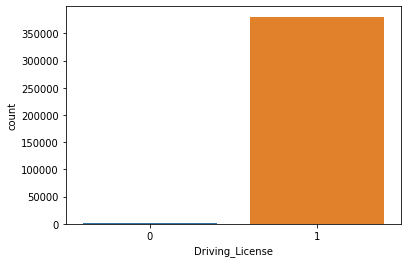

In [33]:
sns.countplot(x='Driving_License', data=df);

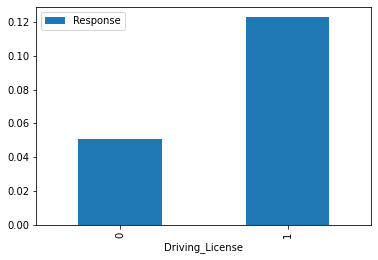

In [34]:
aux1 = df[['Driving_License', 'Response']].groupby('Driving_License').mean();
aux1.plot.bar();


**H6 - Cliente que já tiveram o carro danificado no passado tem mais propensão a comprar o seguro.**

**R:** Verdadeiro. Clientes que já sofreram acidentes contrataram muito mais o seguro.

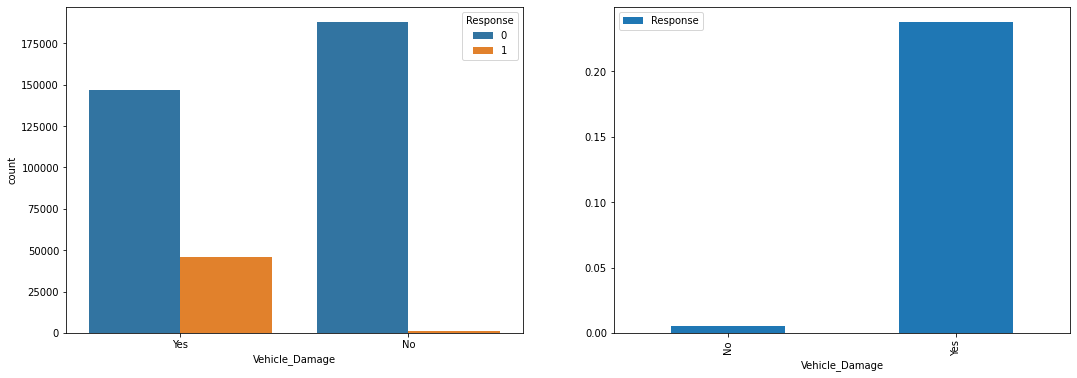

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.countplot(x='Vehicle_Damage',hue='Response', data=df, ax=ax[0])

aux1=df[['Vehicle_Damage', 'Response']].groupby('Vehicle_Damage').mean();
aux1.plot.bar(ax=ax[1]);

 <h1>Mais Hipóteses<h1>

**Quem esta mais propenso a contratar? Quem já tem seguro ou quem ainda não tem?**

**R:** Aparentemente as pessoas que ainda não tem seguro são mais interessadas em contratar do que as pessoas que já tem.

- A porcentagem de pessoas que não tem seguro e contratariam seguro  é 23%
- A porcentagem de pessoas que ja tem seguro e contratariam outro é 0.09%

O total de pessoas que já tem seguro e não estariam interessadas em contratar outro seguro é:  174470
O total de pessoas que já tem seguro e estariam interessadas interessadas em contratar outro seguro é:  158
-----------------------------------------------------------------------------
O total de pessoas que não tem seguro e não estariam interessada em ter seguro é:  159929
O total de pessoas que não tem seguro e estariam interessadas em contratar seguro é:  46552
-----------------------------------------------------------------------------


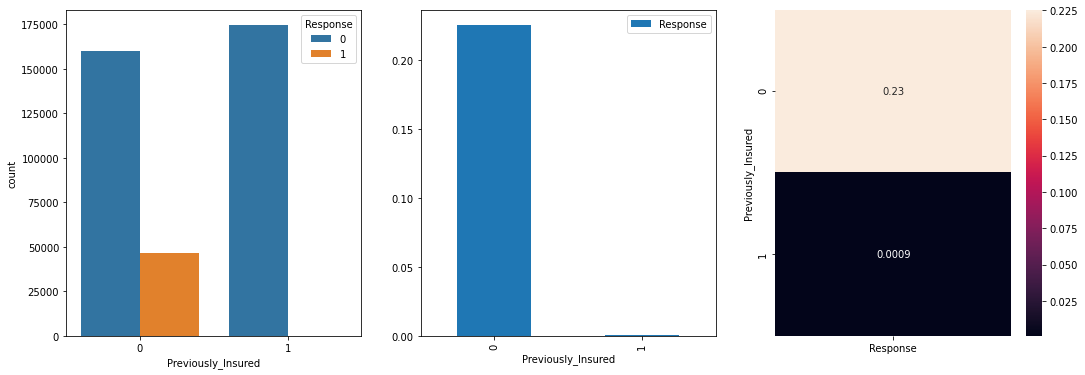

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

sns.countplot(x='Previously_Insured', hue='Response', data=df, ax=ax[0]);

print("O total de pessoas que já tem seguro e não estariam interessadas em contratar outro seguro é: ",
df[(df['Previously_Insured']==1) & (df['Response']==0)].shape[0])

print("O total de pessoas que já tem seguro e estariam interessadas interessadas em contratar outro seguro é: ",
df[(df['Previously_Insured']==1) & (df['Response']==1)].shape[0])

print("-----------------------------------------------------------------------------")

print("O total de pessoas que não tem seguro e não estariam interessada em ter seguro é: ",
df[(df['Previously_Insured']==0) & (df['Response']==0)].shape[0])

print("O total de pessoas que não tem seguro e estariam interessadas em contratar seguro é: ",
df[(df['Previously_Insured']==0) & (df['Response']==1)].shape[0])

print("-----------------------------------------------------------------------------")

aux1 = df[['Previously_Insured', 'Response']].groupby('Previously_Insured').mean();
aux1.plot.bar(ax=ax[1]);

sns.heatmap(aux1, annot=True, ax=ax[2]);

**Qual região possui mais clientes em nossa amostra?**

**R:** A Região 28 é a região que mais possui clientes em nossa amostra.

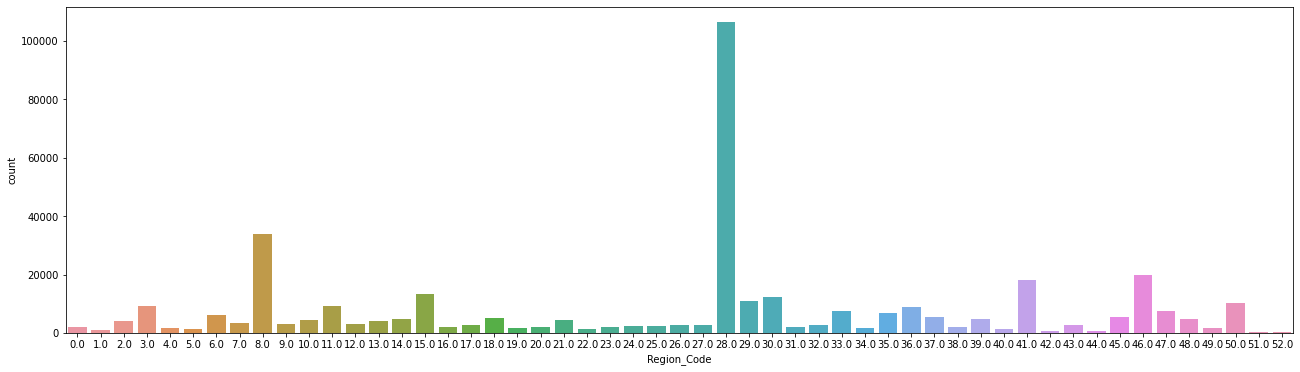

In [37]:
plt.figure(figsize=(22,6))
sns.countplot(x='Region_Code', data=df);

## 4.3 - Análise Multivariada

### Variavéis Númericas

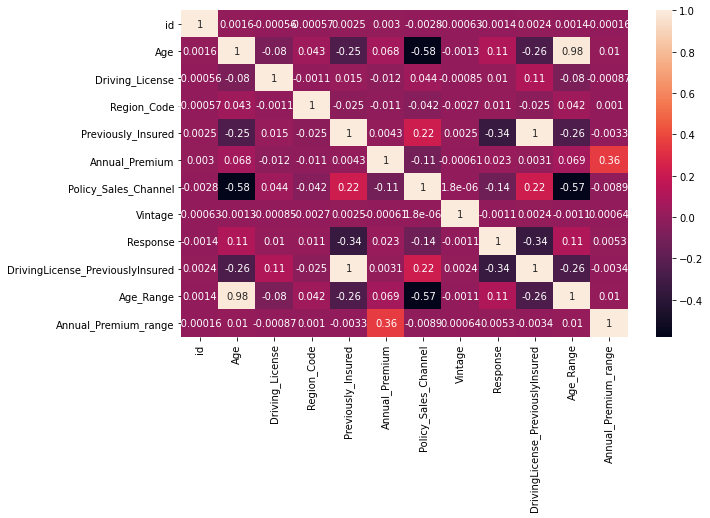

In [38]:
correlation = df_num.corr(method='pearson')
plt.figure(figsize=(10,6))
sns.heatmap(correlation, annot=True);

# 5.0 - Preparação dos Dados

In [202]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response',
       'DrivingLicense_PreviouslyInsured', 'Age_Range',
       'Annual_Premium_range'],
      dtype='object')

In [203]:
X = df.drop(['Response'], axis=1)
y = df['Response']

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
annual_premium = X_test['Annual_Premium']

In [205]:
df2 = pd.concat( [X_train, y_train], axis=1 )

## Standardization

In [206]:
ss_annual_premium = StandardScaler()

df2['Annual_Premium'] = ss_annual_premium.fit_transform(df2[['Annual_Premium']].values)

## Rescalling

In [207]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

df2['Age'] = mms_age.fit_transform(df2[['Age']].values)

df2['Vintage'] = mms_vintage.fit_transform(df2[['Vintage']].values)

## Encoder

In [208]:
#region_code
target_encode_region_code = df.groupby('Region_Code')['Response'].mean()
df2.loc[:, 'Region_Code'] = df2['Region_Code'].map(target_encode_region_code)

#vehicle_age
df2 = pd.get_dummies(df2, prefix='Vehicle_Age', columns=['Vehicle_Age'])
df2 = pd.get_dummies(df2, prefix='Gender', columns=['Gender'])
df2 = pd.get_dummies(df2, prefix='Vehicle_Damage', columns=['Vehicle_Damage'])
df2 = pd.get_dummies(df2, prefix='DrivingLicense_PreviouslyInsured', columns=['DrivingLicense_PreviouslyInsured'])

# Policy_sales_channel
target_encode_policy_sales_channel = df.groupby('Policy_Sales_Channel')['Response'].mean()
df2.loc[:, 'Policy_Sales_Channel'] = df2['Policy_Sales_Channel'].map(target_encode_policy_sales_channel)

In [209]:
target_encode_age_range = df.groupby('Age_Range')['Response'].mean()
df2.loc[:, 'Age_Range'] = df2['Age_Range'].map(target_encode_age_range)

target_encode_annual_premium_range = df.groupby('Annual_Premium_range')['Response'].mean()
df2.loc[:, 'Annual_Premium_range'] = df2['Annual_Premium_range'].map(target_encode_annual_premium_range)

In [210]:
X_test = pd.get_dummies( X_test, prefix='Gender', columns=['Gender'] )

X_test.loc[:, 'Age'] = mms_age.transform(X_test[['Age']].values )

X_test.loc[:, 'Region_Code'] = X_test.loc[:, 'Region_Code'].map( target_encode_region_code )

X_test = pd.get_dummies( X_test, prefix='Vehicle_Age', columns=['Vehicle_Age'] )

X_test = pd.get_dummies( X_test, prefix='Vehicle_Damage', columns=['Vehicle_Damage'] )

X_test.loc[:, 'Annual_Premium'] = ss_annual_premium.transform( X_test[['Annual_Premium']].values )

X_test.loc[:, 'Policy_Sales_Channel'] = X_test['Policy_Sales_Channel'].map(target_encode_policy_sales_channel)

X_test.loc[:, 'Vintage'] = mms_vintage.transform( X_test[['Vintage']].values )

X_test.loc[:, 'Annual_Premium_range'] = X_test['Annual_Premium_range'].map(target_encode_annual_premium_range)

X_test.loc[:, 'Age_Range'] = X_test['Age_Range'].map(target_encode_age_range)

## Conferindo Data

In [211]:
df2.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Age_Range,Annual_Premium_range,...,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Gender_Female,Gender_Male,Vehicle_Damage_No,Vehicle_Damage_Yes,DrivingLicense_PreviouslyInsured_0,DrivingLicense_PreviouslyInsured_1,DrivingLicense_PreviouslyInsured_2
274710,274711,0.030769,1,0.118147,0,-0.297943,0.028624,0.667820,0.044488,0.122491,...,0,1,0,0,1,0,1,0,1,0
216539,216540,0.092308,1,0.096142,1,0.452554,0.199385,0.121107,0.044488,0.122491,...,0,1,0,1,0,1,0,0,0,1
78983,78984,0.184615,1,0.187163,0,0.088559,0.173212,0.086505,0.210051,0.122491,...,0,1,0,1,0,0,1,0,1,0
218368,218369,0.184615,1,0.079258,0,0.412993,0.028624,0.709343,0.210051,0.122491,...,0,1,0,0,1,0,1,0,1,0
307215,307216,0.061538,1,0.187163,0,1.050781,0.215458,0.733564,0.044488,0.122491,...,0,1,0,1,0,0,1,0,1,0


# 6.0 - Feature Selection

### Feature Importance

In [49]:
X_train_n = df2.drop( ['Response', 'id'], axis=1 )
y_train_n = df2['Response']

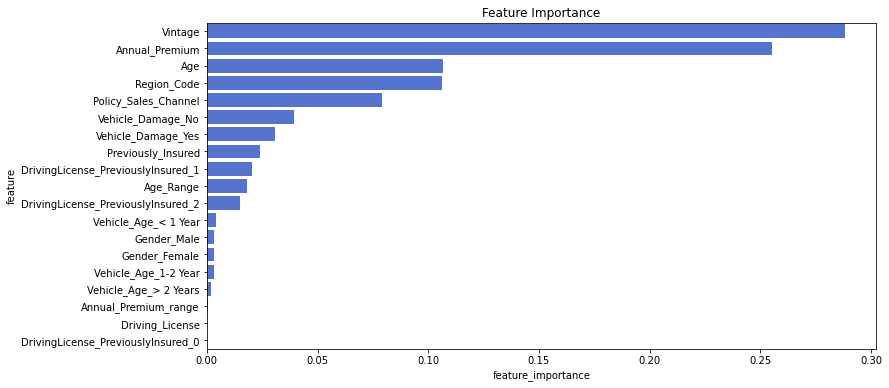

In [50]:
# train random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_n, y_train_n)

# feature importance data frame
feat_imp = pd.DataFrame({'feature': X_train_n.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)


# plot feature importance
plt.subplots(figsize=(12,6))
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

In [51]:
X_train_f = X_train_n[['Vintage', 'Annual_Premium', 'Region_Code', 'Age', 
             'Policy_Sales_Channel', 'Vehicle_Damage_Yes', 'Vehicle_Damage_No', 'Previously_Insured']]

X_test_f = X_test[['Vintage', 'Annual_Premium', 'Region_Code', 'Age', 
             'Policy_Sales_Channel', 'Vehicle_Damage_Yes', 'Vehicle_Damage_No', 'Previously_Insured']]

# 6.0 - Machine Learning

In [52]:
du = DummyClassifier()
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
etx = ExtraTreesClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
xbc = XGBClassifier(eval_metric = 'error')
knn = KNeighborsClassifier()
ada = AdaBoostClassifier()

In [53]:
skf = StratifiedKFold(n_splits=5)

## DummyClassifier

In [68]:
du_result = cross_validation (du,'Dummy', X_train_f, y_train, k=20000)
du_result

,Model Name,Precision,Recall
0,Dummy,0.12,0.3282


## Regressão Logística

In [69]:
lr_result = cross_validation(lr, 'Logistic Regression', X_train_f, y_train, k=20000)
lr_result

,Model Name,Precision,Recall
0,Logistic Regression,0.31,0.8248


## DecisionTreeClassifier

In [70]:
dtc_result = cross_validation(dtc, 'Decision Tree Classifier', X_train_f, y_train, k=20000)
dtc_result

,Model Name,Precision,Recall
0,Decision Tree Classifier,0.17,0.4652


## ExtraTreesClassifier

In [71]:
etx_result = cross_validation(etx, 'Extra Trees Classifier', X_train_f, y_train, k=20000)
etx_result

,Model Name,Precision,Recall
0,Extra Trees Classifier,0.29,0.7642


## RandomForestClassifier

In [72]:
rfc_result = cross_validation(rfc, 'Randon Forest Classifier', X_train_f, y_train, k=20000)
rfc_result

,Model Name,Precision,Recall
0,Randon Forest Classifier,0.29,0.7831


## GradientBoostingClassifier

In [73]:
gbc_result = cross_validation(gbc, 'Gradient Boosting Classifier', X_train_f, y_train, k=20000)
gbc_result

,Model Name,Precision,Recall
0,Gradient Boosting Classifier,0.31,0.8289


## XGBClassifier

In [74]:
xgb_result = cross_validation(xbc, 'XGB Classifier', X_train_f, y_train, k=20000)
xgb_result

,Model Name,Precision,Recall
0,XGB Classifier,0.31,0.8286


## AdaBoost

In [75]:
ada_result = cross_validation(ada, 'AdaBoost Classifier', X_train_f, y_train, k=20000)
ada_result

,Model Name,Precision,Recall
0,AdaBoost Classifier,0.31,0.8253


## KNN

In [76]:
knn_result = cross_validation(knn, 'KNN', X_train_f, y_train, k=20000)
knn_result

,Model Name,Precision,Recall
0,KNN,0.27,0.73


## Results

In [77]:
modelling_result = pd.concat([du_result, lr_result, etx_result, dtc_result, rfc_result,
                             gbc_result, xgb_result, ada_result, knn_result])

modelling_result.sort_values('Precision', ascending=False)

,Model Name,Precision,Recall
0,Logistic Regression,0.31,0.8248
0,Gradient Boosting Classifier,0.31,0.8289
0,XGB Classifier,0.31,0.8286
0,AdaBoost Classifier,0.31,0.8253
0,Extra Trees Classifier,0.29,0.7642
0,Randon Forest Classifier,0.29,0.7831
0,KNN,0.27,0.7300
0,Decision Tree Classifier,0.17,0.4652
0,Dummy,0.12,0.3282


In [36]:
gbc.fit(X_train_f, y_train)

GradientBoostingClassifier()

In [37]:
pred_gbc = gbc.predict_proba(X_test_f)

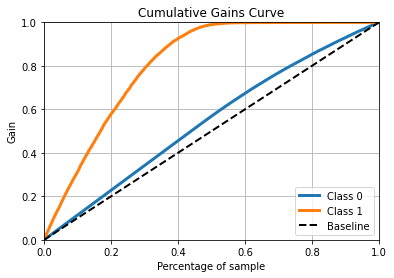

In [38]:
skplt.metrics.plot_cumulative_gain(y_test, pred_gbc);

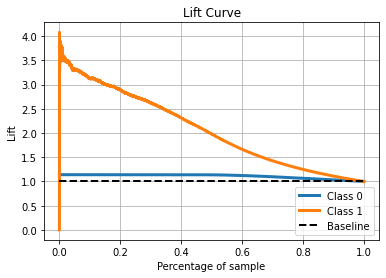

In [39]:
skplt.metrics.plot_lift_curve(y_test, pred_gbc);

In [78]:
lr.fit(X_train_f, y_train)

LogisticRegression()

In [79]:
pred_lr = lr.predict_proba(X_test_f)

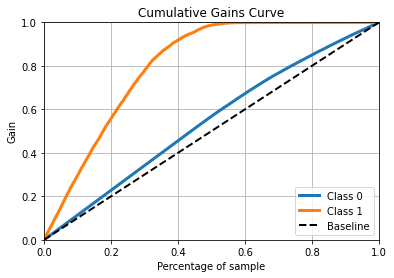

In [80]:
skplt.metrics.plot_cumulative_gain(y_test, pred_lr);

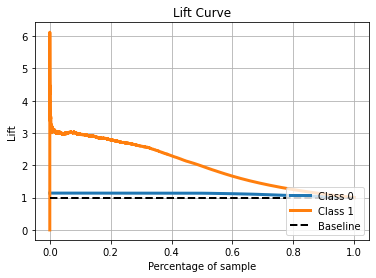

In [81]:
skplt.metrics.plot_lift_curve(y_test, pred_lr);

# 7.0 Business Problem

In [218]:
# Criação do dataset ordenado por interesse
data = X_test.copy()
data = pd.DataFrame(data)
data['response'] = y_test.tolist()
data['score'] = pred_gbc[:, 1].tolist()
data = data.sort_values( 'score', ascending=False )
data = data.reset_index( drop=True )
data['ranking'] = data.index + 1 
data['cumsum'] = data['response'].cumsum()
data = data[['id','score', 'response', 'ranking', 'cumsum']]
data['annual_premium'] = annual_premium.reset_index(drop=True)
data

,id,score,response,ranking,cumsum,annual_premium
0,136373,0.968778,1,1,1,75219.0
1,325025,0.965558,1,2,2,19738.0
2,137332,0.964824,0,3,2,61524.0
3,325462,0.963495,1,4,3,2630.0
4,176217,0.963088,1,5,4,51473.0
...,...,...,...,...,...,...
76217,130072,0.005406,0,76218,9342,32747.0
76218,177310,0.005401,0,76219,9342,2630.0
76219,77228,0.005281,0,76220,9342,36965.0
76220,226803,0.005174,0,76221,9342,28270.0


In [121]:
# Total de Pessoas Interessada no seguro no dataset de teste.
total = data['response'].sum()

In [220]:
rank_20000 = data.head(20000)
total_20000 = rank_20000['response'].sum()
rank_40000 = data.head(40000)
total_40000 = rank_40000['response'].sum()

**Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?**

In [140]:
porcentagem_20000 = total_20000/total
print ('Fazendo 20 mil ligações, o time de vendas conseguirá alcançar {}% dos interessados no seguro'. 
       format(porcentagem_20000.round(2)*100))

Fazendo 20 mil ligações, o time de vendas conseguirá alcançar 69.0% dos interessados no seguro


**Se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?**

In [141]:
porcentagem_40000 = total_40000/total
print ('Fazendo 40 mil ligações, o time de vendas conseguirá alcançar {}% dos interessados no seguro'. 
       format(porcentagem_40000.round(2)*100))

Fazendo 40 mil ligações, o time de vendas conseguirá alcançar 99.0% dos interessados no seguro


**Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?**

In [181]:
print ('80% dos interessados representa {} clientes'.format(total*0.8))

80% dos interessados representa 7473.6 clientes


In [184]:
# Localizando o Ranking da soma cumulativa 7474(número de ligações para impactar 80% dos interessados)
data_80 = data[(data['cumsum']==7474)]
data_80

,id,score,response,ranking,cumsum
24317,216090,0.510022,1,24318,7474


O time de vendas precisará fazer 24318 ligações para contatar 80% dos interessados.

**Supondo que os clientes interessados pagassem 10% do valor do seguro de vida no seguro de carro e supondo que cada ligação custasse R$5,00 para a empresa, qual seria o ROI do modelo de Machine Learning para 20 mil ligações e para 40 mil ligações?**

In [230]:
# Valor ganho com 10% do annual_premium para 20 mil ligações.
interessados_20000 = rank_20000[(data['response']==1)]
valor_20000 = interessados_20000['annual_premium'].apply(lambda x: x*0.1).sum()

In [231]:
# Valor ganho com 10% do annual_premium para 40 mil ligações.
interessados_40000 = rank_40000[(data['response']==1)]
valor_40000 = interessados_40000['annual_premium'].apply(lambda x: x*0.1).sum().round(2)

In [234]:
# Custo 20 mil ligações
custo_20000 = 20000*5

# Custo 40 mil ligações
custo_40000 = 40000*5

# ROI 20 mil ligações
roi_20000 = valor_20000-custo_20000

# ROI 20 mil ligações
roi_40000 = valor_40000-custo_40000

print ('O ROI para 20 mil ligações é R${} e o ROI para 40 mil ligações é R${}'.
      format(roi_20000, roi_40000))

O ROI para 20 mil ligações é R$19620401.7 e o ROI para 40 mil ligações é R$28095422.0


## Respostas 

**1 - Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?**

**R:** Fazendo 20 mil ligações, o time de vendas conseguirá alcançar 69.0% dos interessados no seguro.

**2 - Se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?**

**R:** Fazendo 40 mil ligações, o time de vendas conseguirá alcançar 99.0% dos interessados no seguro.


**3 - Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?**

**R:** O time de vendas precisará fazer 24318 ligações para contatar 80% dos interessados.

**4 - O quanto é melhor usar este modelo de Machine Learning ao invés de ligar aleatóriamente aos clientes**

**R:** Ligando para 20% dos clientes o modelo é 3 vezes melhor do que ligar aleatóriamente e ligando para 40% dos clientes o modelo é cerca de 2,3 vezes melhor do que ligar aleatóriamente.


**5 - Quais as variáveis mais importantes para o modelo de Machine Learning?**

**R:** As variáveis são: Vintage, Annual_Premium, Region_Code, Age, Policy_Sales_Channel, Vehicle_Damage e Previously_Insured.

**6 - Quais são os principais insights?**

- Em média, clientes que pagam de 400 mil a 500 mil são os mais interessados em comprar o seguro.

- Em média, clientes de meia idade (de 31 até 53 anos) tem mais interese em contratar o seguro.

- As pessoas mais jovens (até 30 anos) já tem algum seguro contratado.

- Clientes que já sofreram acidentes contrataram muito mais o seguro.

**7 - Supondo que os clientes interessados pagassem 10% do valor do seguro de vida no seguro de carro e supondo que cada ligação custasse R$5,00 para a empresa, qual seria o ROI do modelo de Machine Learning para 20 mil ligações e para 40 mil ligações?**

**R:** O ROI para 20 mil ligações é 19.620.401,70 e o ROI para 40 mil ligações é 28.095.422,00